# Smoothed Particle Hydrodynamics: Collapase

We import the necessary files

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import time
import math

from numpy.random import seed
from numpy.random import rand
from numba import njit,prange,cuda

from matplotlib import pyplot as plt
import matplotlib

We define this helper function to compute coefficients for the sph kernel below

In [2]:
@njit
def compute_3d_k(n):
    b0 = 2.7012593e-2;
    b1 = 2.0410827e-2;
    b2 = 3.7451957e-3;
    b3 = 4.7013839e-2;

    return b0 + b1 * math.sqrt(n) + b2 * n + b3 * math.sqrt(n * n * n);

Below is the sph kernel function

In [3]:
# This is the SPH Kernel
@njit
def wharmonic(v):
    if (v == 0.0):
        return 1.0;
    Pv = (math.pi / 2.0) * v;
    return math.sin(Pv) / Pv;

We load the initial data.

In [7]:
# Reads the input file
# Calls compute_density
# Write the result in out.txt
# f = open('/scicore/home/scicore/GROUP/gpu_course/pdata')
f = open('/content/drive/MyDrive/pdata')

if f.closed == True:
    print("Error opening file pdata")

n = int(np.fromfile(f, dtype=np.int64, count=1))
ngmax = int(np.fromfile(f, dtype=np.int64, count=1))

x = np.fromfile(f, dtype=np.double, count=n)
y = np.fromfile(f, dtype=np.double, count=n)
z = np.fromfile(f, dtype=np.double, count=n)
h = np.fromfile(f, dtype=np.double, count=n)
m = np.fromfile(f, dtype=np.double, count=n)
neighborsCount = np.fromfile(f, dtype=np.int32, count=n)
neighbors = np.fromfile(f, dtype=np.int32, count=n*ngmax)

f.close()

Now we implement the density function, which updates the density (ro) of every particles based on their x, y, z coordinates and their smoothing length (or radius) h.

In [8]:
# Compute density here
@njit(parallel=True)
def compute_density(n, ngmax, neighbors, neighborsCount, x, y, z, h, m, ro):
    K = compute_3d_k(6.0);

    for i in prange(0, n):
        nn = neighborsCount[i];

        roloc = 0.0;

        for pj in prange(0, nn):
            j = neighbors[i * ngmax + pj];

            xx = x[i] - x[j];
            yy = y[i] - y[j];
            zz = z[i] - z[j];

            dist = math.sqrt(xx * xx + yy * yy + zz * zz);

            # SPH Kernel
            vloc = wharmonic(dist / h[i]);

            w = K * vloc * vloc * vloc * vloc * vloc * vloc;
            value = w / (h[i] * h[i] * h[i]);

            roloc = roloc + value * m[j];

        ro[i] = roloc + m[i] * K / (h[i] * h[i] * h[i]);

We execute the compute_density function.

In [9]:
ro = np.empty([n], dtype=np.double)
start = time.time()
compute_density(n, ngmax, neighbors, neighborsCount, x, y, z, h, m, ro);
end = time.time()
print('Elapsed time: ', end - start)

Elapsed time:  8.74198317527771


In [10]:
# Compute density here
@cuda.jit
def compute_density_cuda(n, ngmax, neighbors, neighborsCount, x, y, z, h, m, ro, K, offset=0):
    tx = cuda.threadIdx.x
    # Block id in a 1D grid
    ty = cuda.blockIdx.x
    # Block width, i.e. number of threads per block
    bw = cuda.blockDim.x
    # Compute flattened index inside the array
    i = offset + tx + ty * bw
    
    if i < n:
        nn = neighborsCount[i];

        roloc = 0.0;

        for pj in prange(0, nn):
            j = neighbors[(i-offset) * ngmax + pj];

            xx = x[i] - x[j];
            yy = y[i] - y[j];
            zz = z[i] - z[j];

            dist = math.sqrt(xx * xx + yy * yy + zz * zz);

            # SPH Kernel
            vloc = wharmonic(dist / h[i]);

            w = K * vloc * vloc * vloc * vloc * vloc * vloc;
            value = w / (h[i] * h[i] * h[i]);

            roloc = roloc + value * m[j];

        ro[i] = roloc + m[i] * K / (h[i] * h[i] * h[i]);

In [11]:
ro = np.empty([n], dtype=np.double)
K = compute_3d_k(6.0)
threadsperblock = 32
blockspergrid = (n + (threadsperblock - 1)) // threadsperblock
start = time.time()
compute_density_cuda[blockspergrid, threadsperblock](n, ngmax, neighbors, neighborsCount, x, y, z, h, m, ro, K, 0)
end = time.time()
print('Elapsed time: ', end - start)

Elapsed time:  1.8817617893218994


In [12]:
ro = np.empty([n], dtype=np.double)
nChunks = 100
start = time.time()

dneighborsCount = cuda.to_device(neighborsCount)
dx = cuda.to_device(x)
dy = cuda.to_device(y)
dz = cuda.to_device(z)
dh = cuda.to_device(h)
dm = cuda.to_device(m)
dro = cuda.to_device(ro)

for i in range(0,nChunks):
    chunkSize = int(n / nChunks)
    offset = chunkSize * i
   # print('Processing stream: ', i, ' with chunkSize: ', chunkSize, ' and offset: ', offset)
    stream = cuda.stream()
    
    b = i * chunkSize * ngmax
    e = (i+1)*chunkSize*ngmax
    dneighbors = cuda.to_device(neighbors[b:e], stream=stream)
    
    K = compute_3d_k(6.0)
    threadsperblock = 32
    blockspergrid = (chunkSize + (threadsperblock - 1)) // threadsperblock
    start = time.time()
    compute_density_cuda[blockspergrid, threadsperblock, stream](n, ngmax, dneighbors, dneighborsCount, dx, dy, dz, dh, dm, dro, K, offset)

    stream.synchronize()
    
ro = dro.copy_to_host()

end = time.time()
print('Elapsed time: ', end - start)

Elapsed time:  0.004372596740722656


In [ ]:
# with open('density.txt', 'w') as f:
#     for i in prange(0, n):
#         f.write(str(x[i]) + " " + str(y[i]) + " " + str(z[i]) + " " + str(h[i]) + " " + str(ro[i]) + "\n")
#         print(str(x[i]) + " " + str(y[i]) + " " + str(z[i]) + " " + str(h[i]) + " " + str(ro[i]))
#     f.close()

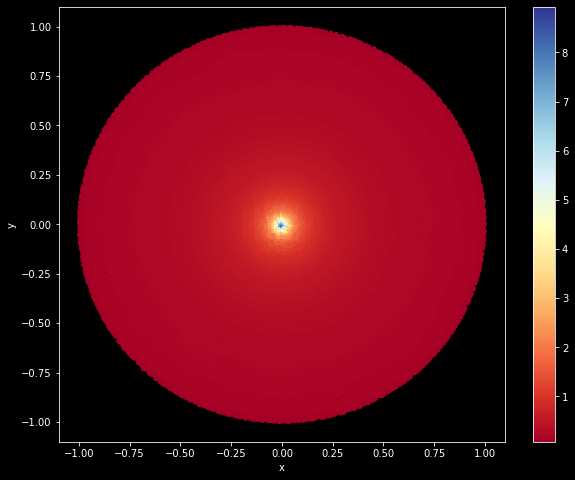

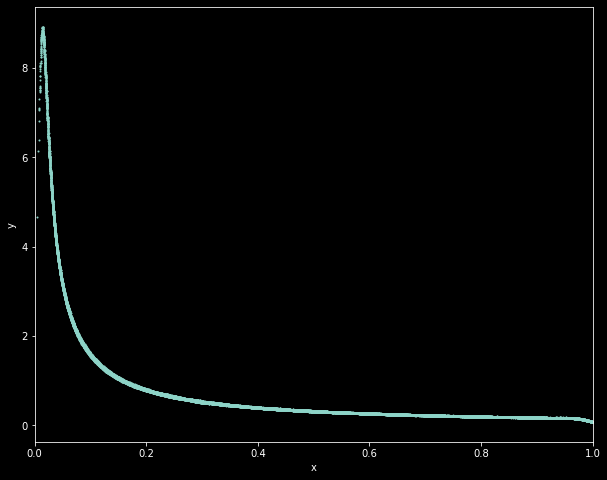

In [13]:
mask = abs(z / h) < 2.0

cm = plt.cm.get_cmap('RdYlBu')

plt.style.use('dark_background')

plt.figure(figsize=(10,8))
# Plot 2D projection a middle cut
sc = plt.scatter(x[mask], y[mask], c=ro[mask], s=10.0, label="Sedov", vmin=min(ro[mask]), vmax=max(ro[mask]), cmap=cm)
plt.colorbar(sc)
plt.xlabel('x')
plt.ylabel('y')
plt.draw()

radius = np.array([math.sqrt(x[i]*x[i]+y[i]*y[i]+z[i]*z[i]) for i in range(len(x))])

plt.figure(figsize=(10,8))
plt.scatter(radius[mask], ro[mask], s=1.0)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0,1])
plt.draw()